<a href="https://colab.research.google.com/github/arangoml/arangopipe/blob/409_and_env_externalization/examples/Arangopipe_Feature_Example_ext1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation Pre-requisites

In [0]:
!pip install python-arango
!pip install -i https://test.pypi.org/simple/ arangopipe
!pip install pandas PyYAML==5.1.1 sklearn2
!pip install jsonpickle
!pip install seaborn
!pip install dtreeviz


     |████████████████████████████████| 81kB 2.6MB/s 
  Created wheel for python-arango: filename=python_arango-5.2.1-py2.py3-none-any.whl size=86479 sha256=0187663ac07a7d253fe403fa3d0df998c6d191236129aa62ce12cc65a9016140
  Stored in directory: /root/.cache/pip/wheels/31/30/00/ef5ee59a25096d89fbb9e2526877f74c189eb6db50bbef9474
Successfully built python-arango
Looking in indexes: https://test.pypi.org/simple/
     |████████████████████████████████| 276kB 2.7MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.1.1-cp36-cp36m-linux_x86_64.whl size=44099 sha256=b31d063517c80a5bf901fc2f3cd41f80fa905021858fb8cb7ba684a41e7f856c
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for dtreeviz: filename=dtreeviz-0.8.1-cp36-none-any

In [0]:
import pandas as pd
import numpy as np
data_url = "https://raw.githubusercontent.com/arangoml/arangopipe/arangopipe_examples/examples/data/cal_housing.csv"
df = pd.read_csv(data_url, error_bad_lines=False)
df.head()

,lat,long,housingMedAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500.0
1,-122.24,37.85,52,1467,190,496,177,7.2574,352100.0
2,-122.25,37.85,52,1274,235,558,219,5.6431,341300.0
3,-122.25,37.85,52,1627,280,565,259,3.8462,342200.0
4,-122.25,37.85,52,919,213,413,193,4.0368,269700.0


# Bias Variance Decompostion of Model Estimates

Bootstrapping is used to estimate the bias of the regression model developed earlier. The bias tells us if the model suffers from systematically overestimating or underestimating at certain regions of the dataset. To illustrate the procedure, a sample of the dataset is used. It just takes longer to run the procedure on the full dataset. For details of the theory, please see:


1. [Section 2.2, Cosma Shalizi](https://www.stat.cmu.edu/~cshalizi/402/lectures/08-bootstrap/lecture-08.pdf)
2. [Tom Dietrich's lecture notes](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf)


In [0]:
from sklearn import linear_model
df['medianHouseValue'] = df['medianHouseValue'].apply(np.log)
preds = df.columns.tolist()
preds.remove('medianHouseValue')
SAMPLE_SIZE = 1000
df = df.sample(n = SAMPLE_SIZE)
df = df.reset_index()

NUM_BOOTSTRAPS = 30
BOOTSTRAP_SAMPLE_SIZE =  df.shape[0] - 1
bootstrap_Yest = {i : list() for i in range(df.shape[0])}
for index in range(df.shape[0]):
    for bootrap_iteration in range(NUM_BOOTSTRAPS):
        dfi = df.iloc[index, :]
        dfb = df.sample(n = BOOTSTRAP_SAMPLE_SIZE, replace=True)
        dfb = dfb.append(dfi)
        X = dfb[preds].values
        Y = dfb['medianHouseValue']

        clf = linear_model.Lasso(alpha=0.001, max_iter = 10000)
        clf.fit(X, Y)
        est_point = X[index, :].reshape(1, -1)
        est_at_index = clf.predict(est_point)
        bootstrap_Yest[index].append(est_at_index)
        
    if index % 100 == 0:
        print('Completed estimating %4d points in the dataset' % (index))

Completed estimating    0 points in the dataset
Completed estimating  100 points in the dataset
Completed estimating  200 points in the dataset
Completed estimating  300 points in the dataset
Completed estimating  400 points in the dataset
Completed estimating  500 points in the dataset
Completed estimating  600 points in the dataset
Completed estimating  700 points in the dataset
Completed estimating  800 points in the dataset
Completed estimating  900 points in the dataset


In [0]:
Xm = df[preds].values
Ym = df['medianHouseValue'].values
clf_0 = linear_model.Lasso(alpha=0.001, max_iter = 10000)
clf_0.fit(Xm, Ym)
Yhat_m = clf_0.predict(Xm)

## Estimating the Bias at each point in the dataset


In [0]:
# see section 2.2 from https://www.stat.cmu.edu/~cshalizi/402/lectures/08-bootstrap/lecture-08.pdf
# see https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf
Expval_at_i = { i : np.mean(np.array(bootstrap_Yest[i])) for i in range(df.shape[0])}
bias_at_i = {i : Expval_at_i[i] - Yhat_m[i] for i in range(df.shape[0])}


## Analysis of the Bias

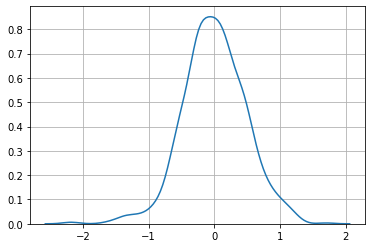

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
bias_values = [bias for (pt, bias) in bias_at_i.items()]
sns.kdeplot(bias_values)
plt.grid(True)

Examine a Kernel Density plot of the bias to see the range of values. 

Note:
The response is log transformed, so the bias must be exponeniated to get the real difference from the true value

In [0]:
from sklearn.cluster import KMeans
cluster_labels = KMeans(n_clusters=5, random_state=0).fit_predict(Xm)
cluster_labels.shape

(1000,)

To see where the model is making mistakes, we cluster the (sample of the) dataset and compute the average bias for each cluster. This provides insights into regions of the data space we are doing well (bias close to zero) and regions where we are not doing well. The table below shows the mean cluster bias and the size of the cluster. We see two large clusters where the bias is close to zero (cluster 0 and cluster 1). We see one outlier with a large error (cluster 3). Clusters 1 and 4 are also seem like outliers and need further analysis. This exercise illustrates how we can examine our model's characteristics. We can now link this model analysis activity to our project using Arangopipe.  

In [0]:
df_bias = pd.DataFrame(Xm)
df_bias['cluster'] = cluster_labels
df_bias['bias'] = bias_values
df_bias.groupby('cluster')['bias'].agg([np.mean, np.size])

,mean,size
cluster,,
0,0.081051,413.0
1,-0.087126,143.0
2,-0.026138,394.0
3,-0.265057,9.0
4,-0.150452,41.0


In [0]:
from arangopipe.arangopipe_storage.arangopipe_api import ArangoPipe
from arangopipe.arangopipe_storage.arangopipe_admin_api import ArangoPipeAdmin
from arangopipe.arangopipe_storage.arangopipe_config import ArangoPipeConfig
from arangopipe.arangopipe_storage.managed_service_conn_parameters import ManagedServiceConnParam
mdb_config = ArangoPipeConfig()
msc = ManagedServiceConnParam()
conn_params = { msc.DB_SERVICE_HOST : "arangoml.arangodb.cloud", \
                        msc.DB_SERVICE_END_POINT : "createDB",\
                        msc.DB_SERVICE_NAME : "createDB",\
                        msc.DB_SERVICE_PORT : 8529,\
                        msc.DB_CONN_PROTOCOL : 'https'}
        
mdb_config = mdb_config.create_connection_config(conn_params)
admin = ArangoPipeAdmin(reuse_connection = False, config = mdb_config)
ap_config = admin.get_config()
ap = ArangoPipe(config = ap_config)
proj_info = {"name": "Housing_Price_Estimation_Project"}
proj_reg = admin.register_project(proj_info)
ds_info = {"name" : "california-housing-dataset",\
            "description": "This dataset lists median house prices in Califoria. Various house features are provided",\
           "source": "UCI ML Repository" }
ds_reg = ap.register_dataset(ds_info)
import numpy as np
df["medianHouseValue"] = df["medianHouseValue"].apply(lambda x: np.log(x))
featureset = df.dtypes.to_dict()
featureset = {k:str(featureset[k]) for k in featureset}
featureset["name"] = "log_transformed_median_house_value"
fs_reg = ap.register_featureset(featureset, ds_reg["_key"]) #
model_info = {"name": "Bias Variance Analysis of LASSO model",  "task": "Model Validation"}
model_reg = ap.register_model(model_info, project = "Housing_Price_Estimation_Project")
import uuid
import datetime
import jsonpickle

ruuid = str(uuid.uuid4().int)
model_perf = {'model_bias': bias_at_i, 'run_id': ruuid, "timestamp": str(datetime.datetime.now())}

mp = clf.get_params()
mp = jsonpickle.encode(mp)
model_params = {'run_id': ruuid, 'model_params': mp}

run_info = {"dataset" : ds_reg["_key"],\
                    "featureset": fs_reg["_key"],\
                    "run_id": ruuid,\
                    "model": model_reg["_key"],\
                    "model-params": model_params,\
                    "model-perf": model_perf,\
                    "tag": "Housing-Price-Hyperopt-Experiment",\
                    "project": "Housing Price Estimation Project"}
ap.log_run(run_info)

API endpoint: https://arangoml.arangodb.cloud:8529/_db/_system/createDB/createDB


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Host Connection: https://arangoml.arangodb.cloud:8529


2020-02-09 21:40:15,934 - arangopipe_logger - ERROR - The dataset by name: heart beat check was not found in Arangopipe!
